In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Load Data

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IGP.csv')

In [ ]:
df.shape

(1028, 2)

In [ ]:
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3336
1,1939-02-01,3.3591
2,1939-03-01,3.4354
3,1939-04-01,3.4608
4,1939-05-01,3.4608


2. Data Preprocessing

In [ ]:
df.isna().sum()

,0
DATE,0
IPG2211A2N,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1028 non-null   object 
 1   IPG2211A2N  1028 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


In [ ]:
#converting the 'DATE' col dtype to 'datetime'
df['DATE'] = pd.to_datetime(df['DATE'])

In [ ]:
# making the 'DATE' col as index
df.set_index('DATE', inplace = True)

In [ ]:
df.head()

,IPG2211A2N
DATE,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608


3. Check whether data is stationary

<Axes: xlabel='DATE'>

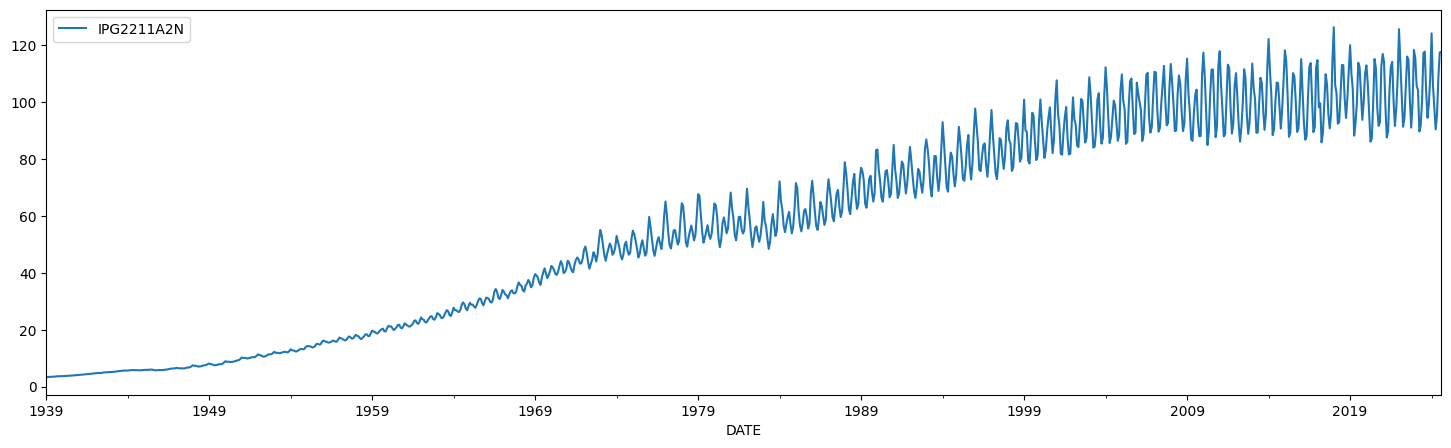

In [ ]:
df.plot(figsize=(18, 5))

In [ ]:
# Augmented Dickey Fuller test
def adf_test(data):
  result = adfuller(data)
  print(f'ADF Statistic : {result[0]}')
  print(f'p-value : {result[1]}')
  if result[1] <= 0.05:
    print('Reject the Null Hypothesis - Data is Stationary')
  else:
    print('Accept the Null Hypothesis - Data is not stationary')

adf_test(df.values)

ADF Statistic : -0.77650950760971
p-value : 0.8259250343111659
Accept the Null Hypothesis - Data is not stationary


In [ ]:
#First Order Differnencing
df['First_Order'] = df['IPG2211A2N'].diff()

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.head()

,IPG2211A2N,First_Order
DATE,,
1939-02-01,3.3591,0.0255
1939-03-01,3.4354,0.0763
1939-04-01,3.4608,0.0254
1939-05-01,3.4608,0.0000
1939-06-01,3.5117,0.0509


In [ ]:
adf_test(df['First_Order'])

ADF Statistic : -10.325795864012887
p-value : 2.9282106280899242e-18
Reject the Null Hypothesis - Data is Stationary


<Axes: xlabel='DATE'>

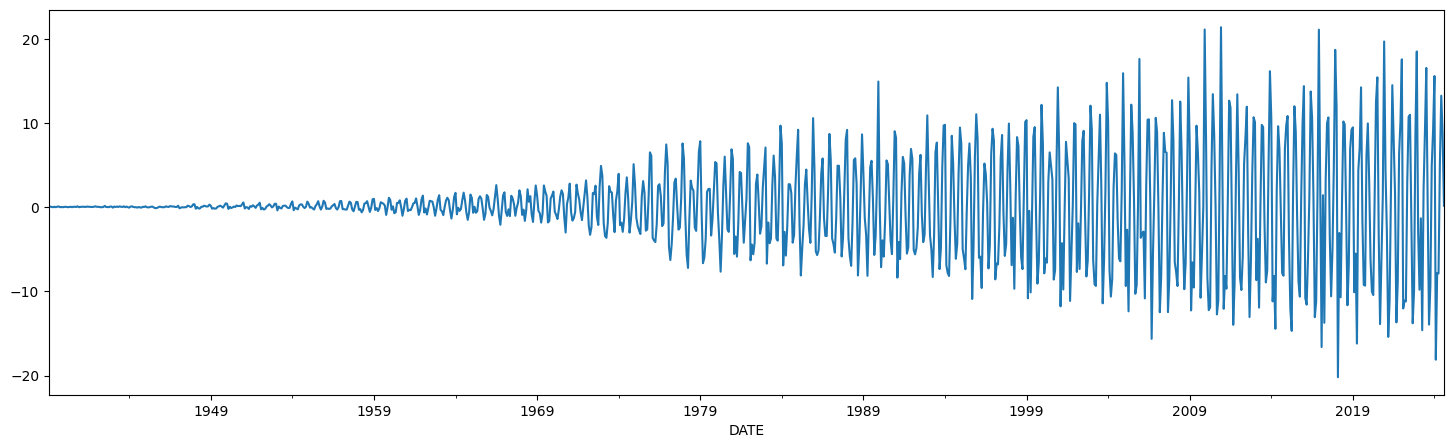

In [ ]:
df['First_Order'].plot(figsize=(18, 5))

4. Train-Test-Split

In [ ]:
0.8 * len(df)

821.6

In [ ]:
train = df[['First_Order']][:822]
test = df[['First_Order']][822:]

In [ ]:
train.shape, test.shape

((822, 1), (205, 1))

5. Determine the ARIMA parameters - p,d,q

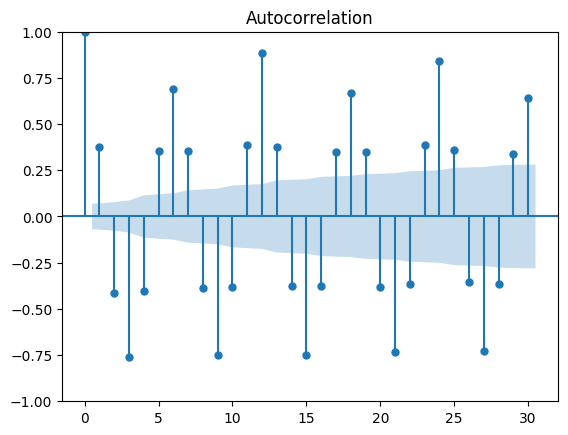

In [ ]:
#acf plot - q
acf = plot_acf(train.values)

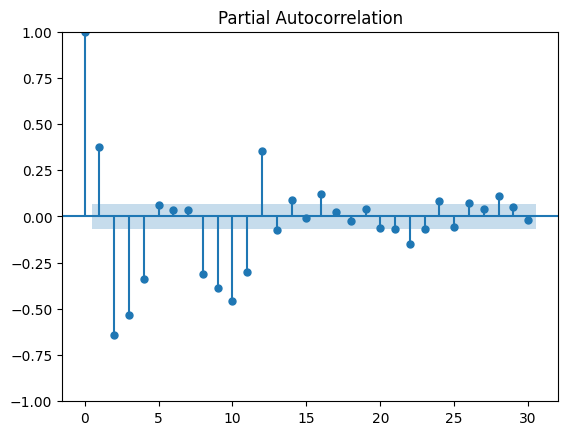

In [ ]:
#pacf plot - p
pacf = plot_pacf(train.values)

In [ ]:
autoArima = auto_arima(train, seasonal=False)

In [ ]:
print(autoArima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1754.822
Date:                Sat, 12 Oct 2024   AIC                           3521.644
Time:                        15:04:53   BIC                           3549.915
Sample:                    02-01-1939   HQIC                          3532.491
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1014      0.068      1.488      0.137      -0.032       0.235
ar.L1          0.9998      0.001    906.310      0.000       0.998       1.002
ar.L2         -0.9995      0.001  -1299.975      0.0

6. Building the ARIMA model

In [ ]:
model = ARIMA(train, order = autoArima.order)

<Axes: xlabel='DATE'>

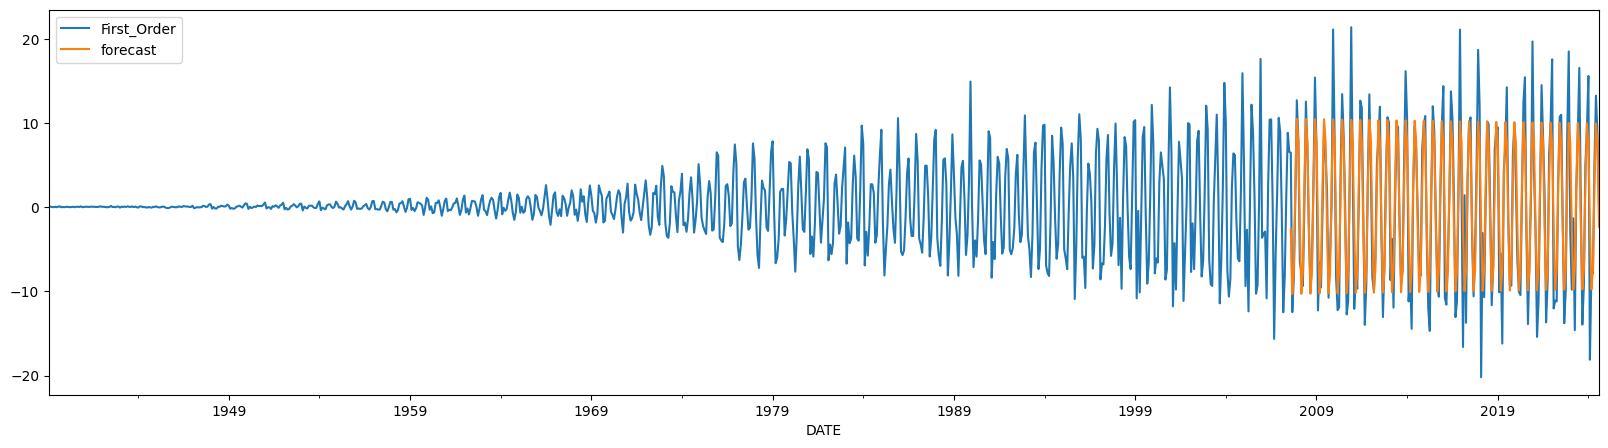

In [ ]:
forecast = autoArima.predict(n_periods = len(test))

df['forecast'] = [None]*len(train) + list(forecast)

df[['First_Order', 'forecast']].plot(figsize=(20, 5))

In [ ]:
df.head()

,IPG2211A2N,First_Order,forecast
DATE,,,
1939-02-01,3.3591,0.0255,NaN
1939-03-01,3.4354,0.0763,NaN
1939-04-01,3.4608,0.0254,NaN
1939-05-01,3.4608,0.0000,NaN
1939-06-01,3.5117,0.0509,NaN


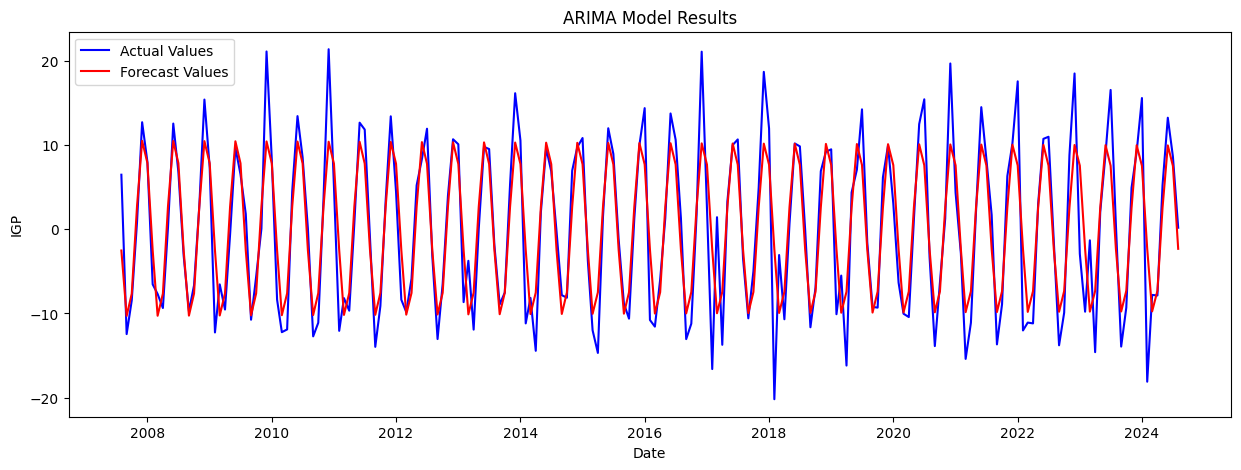

In [ ]:
#plotting the test results

plt.figure(figsize = (15, 5))
plt.plot(df['First_Order'][822:], color = 'blue', label = 'Actual Values')
plt.plot(df['forecast'][822:], color = 'red', label = 'Forecast Values')
plt.title('ARIMA Model Results')
plt.xlabel('Date')
plt.ylabel('IGP')
plt.legend()

In [ ]:
#evaluating metrics
mae = mean_absolute_error(df['First_Order'][822:], df['forecast'][822:])
rmse = np.sqrt(mean_squared_error(df['First_Order'][822:], df['forecast'][822:]))

print(f'Mean Absolute Error (MAE) : {mae}')
print(f'Root Mean Square Error (RMSE) : {rmse}')

Mean Absolute Error (MAE) : 3.307457972904986
Root Mean Square Error (RMSE) : 4.534684280329396
